# Target Encoding — **Customer ID** (LOO) based on *Total Spent*

> Pipeline position: Run this **after** finish `Discount Applied`  imputation.  
> Input: `final_cleaned_dataset.csv` → Output: `encoded_customer_id_dataset.csv`

---

- Encode `Customer ID` (categorical) into a numeric signal that reflects its association with `Total Spent`.
- Use **Leave-One-Out** to reduce target leakage and overfitting.
- Keep the original `Customer ID` column and **add** a new encoded feature for modelling.
- We choose LOO because:
  + Customer ID is an identifier → just a label, not predictive.
  + K-Fold is more complex and mainly useful for predictive categories (like Item or Region), not for identifiers.
  + LOO is simple → each row is encoded using the mean of other rows with the same ID, avoiding self-leakage.

In [ ]:
# === Setup: libraries & file names ===
import pandas as pd
import numpy as np
from pathlib import Path

# Input/Output
CSV_IN = Path("../../output/1_handle_missing_data/final_cleaned_dataset.csv")
CSV_OUT = Path("../../output/2_handle_encoding_data/encoded_customer_id_dataset.csv")

# Column names
CUSTOMER_ID = "Customer ID"
TARGET_COL  = "Total Spent"
ENCODED_COL = "Customer ID Target Encoded"

In [28]:
# === Load data & basic checks ===
df = pd.read_csv(CSV_IN)

In [29]:
# Ensure target is numeric
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# Quick overview
rowCount, colCount = df.shape
nullSummary = df[[CUSTOMER_ID, TARGET_COL]].isnull().sum()

display(df.head(3))
print(f"Rows: {rowCount}, Cols: {colCount}")
print("\nNulls in key columns:")
print(nullSummary)

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_1002182,CUST_01,Food,Item_5_FOOD,11.0,5.0,55.0,Digital Wallet,In-store,2024-10-08,True
1,TXN_1003865,CUST_15,Furniture,Item_2_FUR,6.5,5.0,32.5,Cash,Online,2022-03-12,False
2,TXN_1003940,CUST_06,Furniture,Item_5_FUR,11.0,9.0,99.0,Digital Wallet,Online,2022-04-22,False


Rows: 11971, Cols: 11

Nulls in key columns:
Customer ID    0
Total Spent    0
dtype: int64


### Key Idea
- For each row, we compute the mean of `Total Spent` for the same `Customer ID`, **excluding that row itself**.
- This prevents leakage, because the current target value is not allowed to influence its own encoding.
- If a customer has only one record, we cannot compute a LOO mean. In this case, we replace it with the **global mean**.


In [30]:
# Compute global mean of the target
globalMean = df[TARGET_COL].mean()

# Aggregate sum and count of the target per Customer ID (used to compute leave-one-out means)
joinCustomerTotalSpent = (
    df.groupby(CUSTOMER_ID)[TARGET_COL]
      .agg(sumTotalSpentPerCus="sum", countTotalSpentPerCus="count") # sum and count of target per customer ID
)

# Join the aggregation back to the original rows (align per Customer ID)
df = df.join(joinCustomerTotalSpent, on=CUSTOMER_ID) # add sumTotalSpentPerCus and countTotalSpentPerCus to each row (align per Customer ID)

print(f"Global mean of {TARGET_COL}: {globalMean:.6f}")
df[[CUSTOMER_ID, TARGET_COL, "sumTotalSpentPerCus", "countTotalSpentPerCus"]].head(3)

Global mean of Total Spent: 129.652577


,Customer ID,Total Spent,sumTotalSpentPerCus,countTotalSpentPerCus
0,CUST_01,55.0,58731.5,485
1,CUST_15,32.5,63117.5,501
2,CUST_06,99.0,58632.5,460


In [31]:
# Compute the leave-one-out numerator: group sum minus the current row's target
numeratorSeries = df["sumTotalSpentPerCus"] - df[TARGET_COL] # group sum minus this row's target

# Compute the leave-one-out denominator: group count minus the current row
denominatorSeries = df["countTotalSpentPerCus"] - 1  # group count minus this row

# Compute LOO mean; if denominatorSeries == 0 (customer appears once), result becomes NaN
with np.errstate(divide="ignore", invalid="ignore"):  # ignore divide-by-zero warnings
    looMean = numeratorSeries / denominatorSeries  # leave-one-out mean per row

# Replace NaNs with the global mean
# safe fallback for unseen/rare cases
looMean = looMean.fillna(globalMean)  

# Create the encoded feature (keep original Customer ID column)
df[ENCODED_COL] = looMean  # add new encoded column to the dataframe

# Drop helper columns to keep the output tidy
df = df.drop(columns=["sumTotalSpentPerCus", "countTotalSpentPerCus"])

# Quick look at the new encoded feature
df[[CUSTOMER_ID, TARGET_COL, ENCODED_COL]].head(5)

,Customer ID,Total Spent,Customer ID Target Encoded
0,CUST_01,55.0,121.232438
1,CUST_15,32.5,126.170000
2,CUST_06,99.0,127.523965
3,CUST_04,123.0,135.780837
4,CUST_08,70.0,132.967391


In [32]:
# Diagnostics: spot checks
# IDs with single occurrence should equal global mean
idCounts = df[CUSTOMER_ID].value_counts()
singletons = idCounts[idCounts == 1].index[:5]

if singletons.empty:
    print("No singleton IDs found — every Customer ID appears more than once.")
else:
    print("Sample singleton IDs (encoded should equal global mean):", list(singletons))
    print(df[df[CUSTOMER_ID].isin(singletons)][[CUSTOMER_ID, TARGET_COL, ENCODED_COL]].head(10))

No singleton IDs found — every Customer ID appears more than once.


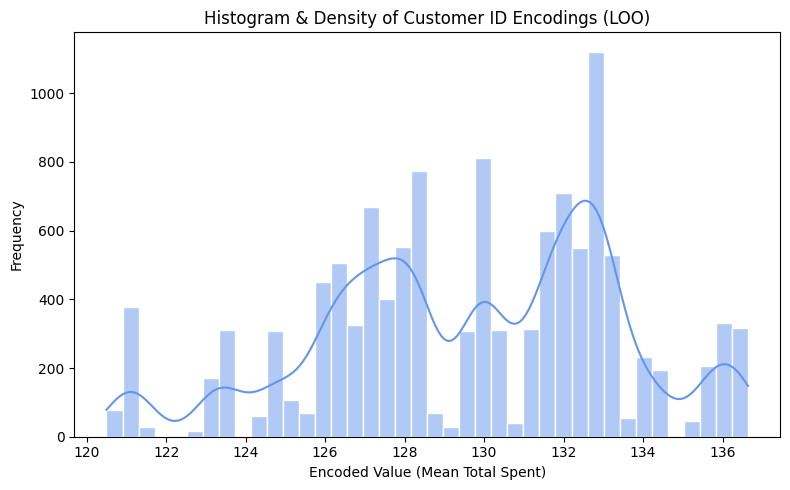

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(
    df[ENCODED_COL],
    bins=40,
    kde=True,
    color="cornflowerblue",
    edgecolor="white"
)
plt.title("Histogram & Density of Customer ID Encodings (LOO)")
plt.xlabel("Encoded Value (Mean Total Spent)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

- X-axis: the encoded value—the average Total Spent that each customer ID is associated with after LOO smoothing.
- Y-axis: number of customers (histogram bars) or relative density (blue KDE line). Taller bars mean many customers share that spend level.
- Most customers fall between about 125 and 133, with the peak of the density curve right around 130; that’s the “typical” customer spend in the encoded feature.
- The smooth line is a density estimated. Peaks line up with where the histogram is tallest.
- The main hump centers near 130, then tails taper off toward 120 on the left and 136 on the right. Those tails correspond to the 1st and 99th percentiles (≈121 and ≈136.5).
- Most customers’ encoded spend is around 130, with gentle variation on either side, and only a few high- or low-spend outliers

In [34]:
# === Save encoded dataset ===
df.to_csv(CSV_OUT, index=False)
print(f"Saved: {CSV_OUT.resolve()}")
print(f"New column: {ENCODED_COL} (global mean fallback = {globalMean:.6f})")

Saved: D:\CP610\handle_encoding_data\output_data\1_customer_id\encoded_customer_id_dataset.csv
New column: Customer ID Target Encoded (global mean fallback = 129.652577)
